# sequence

## 0. Discussion

## 1. Image calibration
## 2. Threshold image
## 3. Warp image
## 4. Fine lane (IF NOT DETECTED)
## 5. Find lane (IF DETECTED)
## 6. Calculate curvature
## 7. Fill green color inside of lanes
## 8. Write curve data on image
## 9. Define Line Class
## 10. Final code (Include everything)
## 11. Check intermediate result
## 12. Make video

---

# 0. Discussion


Unexpectively, deciding what threshold to accept was hard part because it needs so many fine tunings

And even though it was good at picture, it did not guarantee it will be good at every video frames

Depending on road condition, expecially non-pavement or shawdow or curvature, I tried so many combination

Firstly I combine gradient, saturation threshold but it cannot classify lanes at shadow

As a result, I add lab-b threshold

But that combination detect so many coordinates so that found lane was not fitted

As a result, I just combined saturation, lab-b threshold

It was good at normal condition, but that combination cannot detect lanes at non pavement and shadow and curve

So I modified self.diff coefficient more easily and add lightness saturation to combination

It detect well so that average line was almost good at every frames

But if I have more time I want to do more tunings

At now I ignore too much diffrence of polynimial coefficient between new one and before detected

But in principle, it cannot detect such a big different polynimial

So as a supplement it need to detect line more accuratly

or eventhough detected line was not good, it have to method not to ignore but use it


Import modules I need

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. image calibration

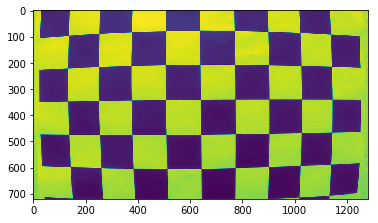

In [2]:
test_fname = './frame.jpeg'
test_img = mpimg.imread(test_fname)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img)

cam_cal_fname = './camera_cal/calibration1.jpg'
cam_cal_img = mpimg.imread(cam_cal_fname)
cam_cal_img_gray = cv2.cvtColor(cam_cal_img, cv2.COLOR_RGB2GRAY)
plt.imshow(cam_cal_img_gray)

In [3]:
def cam_cal(cam_cal_img_gray):
    
    nx = 9
    ny = 5

    ret, corners = cv2.findChessboardCorners(cam_cal_img_gray, (nx,ny), None)

    if ret == True:
        cv2.drawChessboardCorners(cam_cal_img, (nx,ny), corners, ret)
        #plt.imshow(cam_cal_img)

    objpoints = []
    imgpoints = []

    objp = np.zeros((9*5, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cam_cal_img_gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def undistort_img(img_gray, mtx, dist):
    
    undistorted_img = cv2.undistort(img_gray, mtx, dist, None, mtx)
    
    return undistorted_img



In [4]:
ret, mtx, dist, rvecs, tvecs = cam_cal(cam_cal_img_gray)

undistorted_img = undistort_img(test_img, mtx, dist)

#img_rgb = undistorted_img
#img_gray = img_gray(img_rgb)
#img_hls = img_hls(img_rgb)

#plt.imshow(img_gray)

# 2. Threshold image 

In [5]:
def abs_sobel_thresh(img_gray, orient='x', thresh_min=0, thresh_max=255):

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img_gray, sobel_kernel=3, mag_thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img_gray, sobel_kernel=3, thresh=(np.pi/10, np.pi/3)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def combined_gradient(img_gray):
    
    gradx = abs_sobel_thresh(img_gray, orient='x', thresh_min=30, thresh_max=255)
    grady = abs_sobel_thresh(img_gray, orient='y', thresh_min=30, thresh_max=255)
    dir_binary = mag_thresh(img_gray, sobel_kernel=3, mag_thresh=(30, 255))
    mag_binary = dir_threshold(img_gray, sobel_kernel=3, thresh=(0.5, 1.3))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_gradient



def sat_threshold(img_hls, thresh = (170, 255)):
    
    s_channel = img_hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def lightness_thresh(img_hls, thresh=(220, 255)):
    # 1) Convert to HLS color space
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = img_hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_b_thresh(img_lab, thresh=(190,255)):
    # 1) Convert to LAB color space
    #lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = img_lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output


def combined_gradient_threshold(img_gray, img_hls, img_lab):
    
    combined_gradient_img = combined_gradient(img_gray)
    sat_binary = sat_threshold(img_hls, thresh = (170, 255))
    lightness_binary = lightness_thresh(img_hls, thresh = (220,255))
    lab_b_binary = lab_b_thresh(img_lab, thresh = (190,255))

    combined_binary = np.zeros_like(sat_binary)
    #combined_binary[(combined_gradient_img == 1) | (sat_binary == 1) | (lightness_binary == 1) | (lab_b_binary == 1)] = 1
    combined_binary[(sat_binary == 1) | (lightness_binary == 1) | (lab_b_binary == 1)] = 1
    #combined_binary[(lightness_binary == 1) | (lab_b_binary == 1)] = 1

    return combined_binary

# 3. Warp image

In [6]:
def warp(combined_binary):
    
    #combined_binary = combined_gradient_threshold(img_gray, img_hls)

    src = np.float32(
        [[780,470],
         [1180,650],
         [150,750],
         [500,470]])

    dsr = np.float32(
        [[1250,0],
         [1200,700],
         [50,700],
         [50,0]])

    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    M = cv2.getPerspectiveTransform(src, dsr)
    Minv = cv2.getPerspectiveTransform(dsr, src)
    
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags = cv2.INTER_LINEAR)

    #plt.imshow(warped)
    
    return [warped,Minv]

# 4. Find lane (IF NOT DETECTED)

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 200

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return [out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds]

# 5. Find lane (IF DETECTED)

In [8]:
def fit_prev_polynomial(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
             
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    try:
        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return [out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds]

# 6. Calculate curvature & distance from center

In [9]:
def calculate_curve_and_distance(img_warp, left_lane_inds, right_lane_inds):
    
    ym_per_pix = 3.048/170 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters, in the image it was 170pixels
    xm_per_pix = 3.7/900 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters, in the image it was 900pixels
    
    y_max = img_warp.shape[0]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_warp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Fit polynomials to x,y in camera space
    left_fit_x = np.polyfit(lefty, leftx, 2)
    right_fit_x = np.polyfit(righty, rightx, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_max*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_max*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    car_position = img_warp.shape[1]/2
    lane_start_point_left = left_fit_x[0]*y_max**2 + left_fit_x[1]*y_max + left_fit_x[2]
    lane_start_point_right = right_fit_x[0]*y_max**2 + right_fit_x[1]*y_max + right_fit_x[2]
    lane_center_position = (lane_start_point_left + lane_start_point_right) / 2
    center_distance = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_distance

# 7. Fill green color inside of lanes

In [10]:
def fill_color_in_line(img_warp, left_fitx, right_fitx, ploty, undistort, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=30)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.7, 0)
    #plt.imshow(result)

    return result

# 8. Write curve data on image

In [11]:
def write_curve_data(color_filled_img, left_curverad, right_curverad, center_distance):
    
    curve_in_img = np.copy(color_filled_img)
    #h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    curve_rad = (left_curverad + right_curverad) / 2
    
    text = 'Curve radius: ' + '{:04.2f}'.format(curve_rad) + 'm'
    cv2.putText(curve_in_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    abs_center_distance = abs(center_distance)
    if center_distance > 0:
        direction = 'right'
        text = 'Distance from center : ' + '{:04.3f}'.format(abs_center_distance) + 'm to ' + direction
        cv2.putText(curve_in_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)          
    else:
        direction = 'left'
        text = 'Distance from center : ' + '{:04.3f}'.format(abs_center_distance) + 'm to ' + direction
        cv2.putText(curve_in_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)    
    
    return curve_in_img

# 9. Define Line Class

In [12]:
class Line():
    def __init__(self):
        self.detected = False
        self.fitx5 = []
        self.lane_inds = []
        self.average_fitx5 = None
        self.diff = np.array([0,0,0], dtype = 'float')
        
    def add_fit(self, fit, lane_inds):
        
        if fit is not None:
            
            if self.average_fitx5 is not None:
                self.diff = abs(self.average_fitx5-fit)
            
            if (self.diff[0] > 100 or self.diff[1] > 500 or self.diff[2] > 1000):
                self.detected = False
                
            else:
                self.fitx5.append(fit)
            
                if len(self.fitx5) > 10:
                    # erase old fits, keep newest n
                    self.fitx5 = self.fitx5[len(self.fitx5)-10:]

                self.average_fitx5 = np.average(self.fitx5, axis=0)
            
        else:
            self.detected = False
            #if len(self.fitx5) > 1:
                # erase oldest fit
            #    self.fitx5 = self.fitx5[:len(self.fitx5)-1]
            #self.average_fitx5 = np.average(self.fitx5, axis=0)
            
        self.lane_inds = lane_inds
        
L_line = Line()
R_line = Line()

# 10. Final code (Include everything)

In [13]:
def process_image(img_rgb):
    
    undistorted_img = undistort_img(img_rgb, mtx, dist)
    img_gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    img_hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
    img_lab = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2LAB)
    
    combined_binary = combined_gradient_threshold(img_gray, img_hls, img_lab)
    
    img_warp = warp(combined_binary)[0]
    Minv = warp(combined_binary)[1]
    
    if not L_line.detected or not R_line.detected:
        out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = fit_polynomial(img_warp)
        #L_line.fitx = left_fitx
        #R_line.fitx = right_fitx
        
        #L_line.lane_inds = left_lane_inds
        #R_line.lane_inds = right_lane_inds
        
    else:
        out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = fit_prev_polynomial(img_warp, L_line.average_fitx5, R_line.average_fitx5)
        #L_line.fitx = left_fitx
        #R_line.fitx = right_fitx
        
        #L_line.lane_inds = left_lane_inds
        #R_line.lane_inds = right_lane_inds
        
    L_line.add_fit(left_fitx, left_lane_inds)
    R_line.add_fit(right_fitx, right_lane_inds)
        
    left_curverad, right_curverad, center_distance = calculate_curve_and_distance(img_warp, L_line.lane_inds, R_line.lane_inds)
        
    color_filled_img = fill_color_in_line(img_warp, L_line.average_fitx5, R_line.average_fitx5, ploty, undistorted_img, Minv)
    
    result = write_curve_data(color_filled_img, left_curverad, right_curverad, center_distance)
    
    return result   

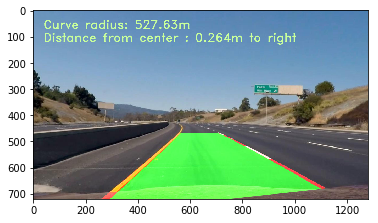

In [14]:
plt.imshow(process_image(test_img))

# 11. Check intermediate result

In [14]:
# 1
before_calibration_image = cam_cal_img
# 2
after_calibration_image = undistort_img(cam_cal_img, mtx, dist)
# 3
before_calibration_test_image = test_img
# 4
after_calibration_test_image = undistort_img(test_img, mtx, dist)

img_gray = cv2.cvtColor(after_calibration_test_image, cv2.COLOR_RGB2GRAY)
img_hls = cv2.cvtColor(after_calibration_test_image, cv2.COLOR_RGB2HLS)
img_lab = cv2.cvtColor(after_calibration_test_image, cv2.COLOR_RGB2LAB)

# 5
after_threshold_image = combined_gradient_threshold(img_gray, img_hls, img_lab)
# 6
after_warp_image = warp(after_threshold_image)[0]
# 7
after_finding_lane_image = fit_polynomial(after_warp_image)[0]

ploty = fit_polynomial(after_warp_image)[1]
left_fitx = fit_polynomial(after_warp_image)[2]
right_fitx = fit_polynomial(after_warp_image)[3]
left_lane_inds = fit_polynomial(after_warp_image)[4]
right_lane_inds = fit_polynomial(after_warp_image)[5]
Minv = warp(after_threshold_image)[1]
left_curve_rad, right_curve_rad, center_distance = calculate_curve_and_distance(after_warp_image, left_lane_inds, right_lane_inds)

# 8
after_fill_green_color_image = fill_color_in_line(after_warp_image, left_fitx, right_fitx, ploty, after_calibration_test_image, Minv)
# 9
after_write_curvature_image = write_curve_data(after_fill_green_color_image, left_curve_rad, right_curve_rad, center_distance)

Text(0.5,1,'AFTER_WRITING_CURVE_DATA_IMAGE.png')

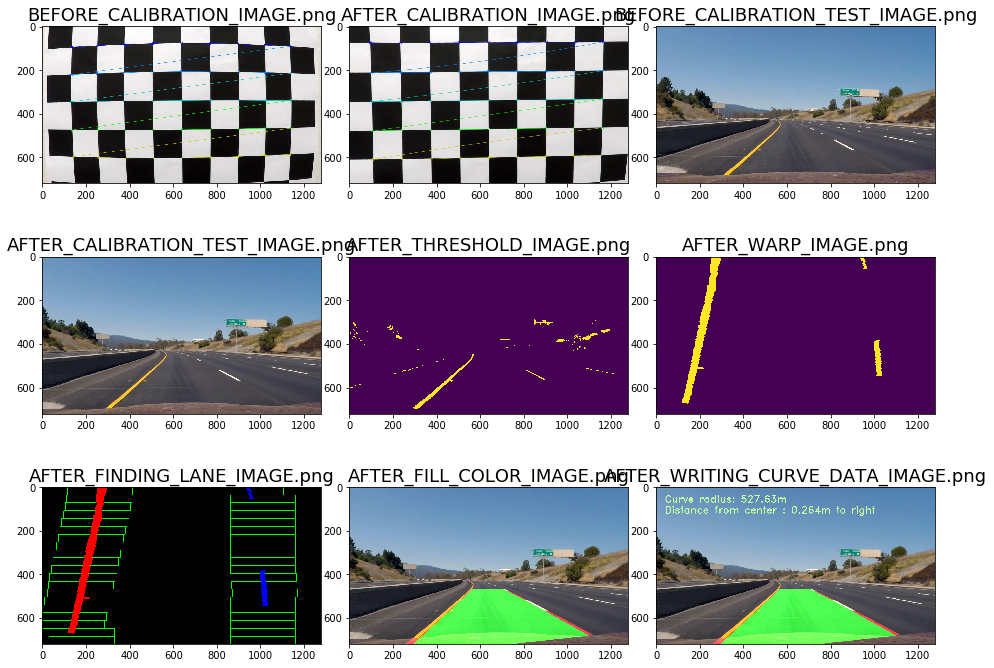

In [15]:
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

axs[0].imshow(before_calibration_image)
axs[0].set_title('BEFORE_CALIBRATION_IMAGE.png', fontsize=18)

axs[1].imshow(after_calibration_image)
axs[1].set_title('AFTER_CALIBRATION_IMAGE.png', fontsize=18)

axs[2].imshow(before_calibration_test_image)
axs[2].set_title('BEFORE_CALIBRATION_TEST_IMAGE.png', fontsize=18)

axs[3].imshow(after_calibration_test_image)
axs[3].set_title('AFTER_CALIBRATION_TEST_IMAGE.png', fontsize=18)

axs[4].imshow(after_threshold_image)
axs[4].set_title('AFTER_THRESHOLD_IMAGE.png', fontsize=18)

axs[5].imshow(after_warp_image)
axs[5].set_title('AFTER_WARP_IMAGE.png', fontsize=18)

axs[6].imshow(after_finding_lane_image)
axs[6].set_title('AFTER_FINDING_LANE_IMAGE.png', fontsize=18)

axs[7].imshow(after_fill_green_color_image)
axs[7].set_title('AFTER_FILL_COLOR_IMAGE.png', fontsize=18)

axs[8].imshow(after_write_curvature_image)
axs[8].set_title('AFTER_WRITING_CURVE_DATA_IMAGE.png', fontsize=18)


In [17]:
plt.imsave("BEFORE_CALIBRATION_IMAGE.png", before_calibration_image)
plt.imsave("AFTER_CALIBRATION_IMAGE.png", after_calibration_image)
plt.imsave("BEFORE_CALIBRATION_TEST_IMAGE.png", before_calibration_test_image)
plt.imsave("AFTER_CALIBRATION_TEST_IMAGE.png", after_calibration_test_image)
plt.imsave("AFTER_THRESHOLD_IMAGE.png", after_threshold_image)
plt.imsave("AFTER_WARP_IMAGE.png", after_warp_image)
plt.imsave("AFTER_FINDING_LANE_IMAGE.png", after_finding_lane_image)
plt.imsave("AFTER_FILL_COLOR_IMAGE.png", after_fill_green_color_image)
plt.imsave("AFTER_WRITING_CURVE_IMAGE.png", after_write_curvature_image)

# 12. Make video

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
white_output = 'test_videos_output/project_video_4.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_4.mp4
[MoviePy] Writing video test_videos_output/project_video_4.mp4


100%|█████████▉| 1260/1261 [10:25<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_4.mp4 

CPU times: user 6min 37s, sys: 1min 34s, total: 8min 11s
Wall time: 10min 28s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
import cv2

vidcap = cv2.VideoCapture('project_video.mp4')
#count = 0

#while(vidcap.isOpened()):
#    ret, image = vidcap.read()
 
#    if(int(vidcap.get(1)) % 25 == 0):
#        print('Saved frame number : ' + str(int(vidcap.get(1))))
#        cv2.imwrite("../test_images/frame%d.jpg" % count, image)
#        print('Saved frame%d.jpg' % count)
#        count += 1
